In [25]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas.tseries.offsets import BusinessDay
from calculate_stats import calculate_model_performance_stats

In [26]:
total = 5370+4440+4190+3790+580
print(total)

18370


In [27]:
def prepare_portfolio_df(start, end, tickers, base=1000):
    """
    Prepares a portfolio DataFrame with percentage changes, cumulative returns,
    and portfolio value given tickers, weights, and initial total investment.

    Parameters:
        start (datetime): Start date for data retrieval.
        end (datetime): End date for data retrieval.
        tickers (list): List of stock tickers.
        weights (dict): Dictionary with tickers as keys and weights as values.
        total (float): Initial portfolio value. Default is 1,000,000.

    Returns:
        pd.DataFrame: DataFrame with portfolio value and other metrics.
    """
    if not tickers:
        raise ValueError("Tickers list cannot be empty.")

    if sum(abs(x) for x in tickers.values()) > 1:
        raise ValueError("total of weight > 1")
    
    # Initialize an empty DataFrame
    df = pd.DataFrame(index=pd.bdate_range(start=start, end=end-BusinessDay(1)))

    # Download data and calculate percentage changes
    for ticker in tickers.keys():
        curr = yf.download(ticker, start=start, end=end)
        curr.columns = curr.columns.get_level_values(0)
        # df = pd.concat([df, curr[["Close"]]],axis=1).ffill().bfill()
        curr.rename(columns={"Close": ticker+"_Close"}, inplace=True)
        df = df.merge(curr[[ticker+"_Close"]], left_index=True, right_index=True, how="left").ffill().bfill()

    # print(df.columns)
    for ticker in tickers.keys():
        column_name = ticker+'_Close'
        df[ticker+"_pct_change"] = df[column_name].pct_change().fillna(0)

    # Calculate portfolio percentage change
    df["pf_pct_change"] = sum(
        df[ticker + "_pct_change"] * tickers[ticker] for ticker in tickers.keys()
    )

    # # Calculate cumulative returns and portfolio value
    df["cumulative_returns"] = (1 + df["pf_pct_change"]).cumprod()
    df["pf_val"] = base * df["cumulative_returns"]

    return df

In [28]:
start = "2025-01-01"
end = datetime.date.today()
# end = "2025-01-13"
tickers = {"UTWO": .5, "GLD": .25, "SPY": .25}
# tickers = {"UTWO": 0, "GLD": 0, "SPY": 1}

print(.5, .25, .25, total)
print(sum(abs(x) for x in tickers.values()))

df_curr = prepare_portfolio_df(start, end, tickers, base=1000)
print("annualised vol=",df_curr.pf_pct_change.std()*np.sqrt(365))
print("30-days vol=",df_curr.pf_pct_change.iloc[-30:].std()*np.sqrt(365))
calculate_model_performance_stats(df_curr, "pf_val", base=1000)

0.5 0.25 0.25 18370
1.0


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


annualised vol= 0.05483087490047295
30-days vol= 0.05483087490047295


{'pf_val': 1025.7721989795152,
 'pf_val_returns': 0.025772198979515215,
 'pf_val_sharpe': 6.130163506562111,
 'pf_val_mdd': 0.005358756487401025}

0.5004078361474302


count    25.000000
mean      0.001022
std       0.002870
min      -0.005359
25%      -0.000525
50%       0.001033
75%       0.002021
max       0.007305
Name: pf_pct_change, dtype: float64

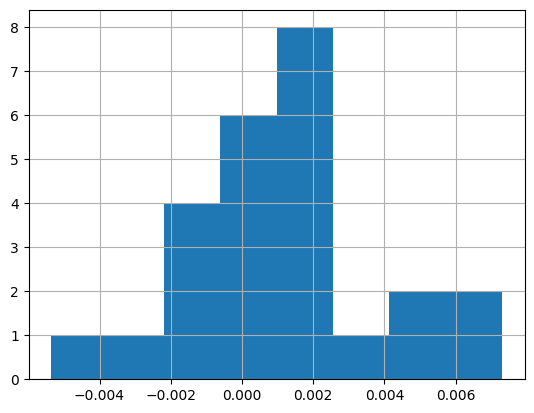

In [29]:
plt.hist(df_curr.pf_pct_change, bins="auto")
plt.grid(True)
print(1-norm.cdf(0,df_curr.pf_pct_change.mean()))
df_curr["pf_pct_change"].describe()

In [30]:
start = "2025-01-01"
end = datetime.date.today()
# end = "2009-01-01"
tickers = {"UUP": 0.25, "JPY=X": 0, "IBIT": .05, "XLU": 0.0, "XLF": 0.0, "XLC":0.0, "XLY":0, "GLD": .20, "SPY": .25, "SHY": .25, "USDCNY=X": 0}
# tickers = {"UUP": 0.25, "JPY=X": 0, "IBIT": .05, "XLU": 0.1, "XLF": 0.0, "XLC":0.0, "XLY":0, "GLD": .20, "SPY": .20, "SHY": .20, "USDCNY=X": 0}

df = prepare_portfolio_df(start, end, tickers, base=1000)

print(sum(abs(x) for x in tickers.values()))
print([{ticker:abs(weight)*total} for ticker, weight in tickers.items()])
print([{ticker:abs(weight)*total} for ticker, weight in tickers.items() if weight > 0])

print("annualised vol=",df.pf_pct_change.std()*np.sqrt(365))
print("30-days vol=",df.pf_pct_change.iloc[-30:].std()*np.sqrt(365))
calculate_model_performance_stats(df, "pf_val")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1.0
[{'UUP': 4592.5}, {'JPY=X': 0}, {'IBIT': 918.5}, {'XLU': 0.0}, {'XLF': 0.0}, {'XLC': 0.0}, {'XLY': 0}, {'GLD': 3674.0}, {'SPY': 4592.5}, {'SHY': 4592.5}, {'USDCNY=X': 0}]
[{'UUP': 4592.5}, {'IBIT': 918.5}, {'GLD': 3674.0}, {'SPY': 4592.5}, {'SHY': 4592.5}]
annualised vol= 0.05539041847686802
30-days vol= 0.05539041847686802


{'pf_val': 1020.3501525856957,
 'pf_val_returns': 0.020350152585695724,
 'pf_val_sharpe': 4.634524794387943,
 'pf_val_mdd': 0.0069575092063784705}

In [31]:
df.tail()

,UUP_Close,JPY=X_Close,IBIT_Close,XLU_Close,XLF_Close,XLC_Close,XLY_Close,GLD_Close,SPY_Close,SHY_Close,...,XLF_pct_change,XLC_pct_change,XLY_pct_change,GLD_pct_change,SPY_pct_change,SHY_pct_change,USDCNY=X_pct_change,pf_pct_change,cumulative_returns,pf_val
2025-01-29,29.389999,155.559006,59.340000,76.739998,51.279999,101.870003,230.940002,254.199997,601.809998,81.957199,...,-0.000779,0.004437,-0.002850,-0.003840,-0.004483,-0.000608,-0.000069,-0.000001,1.016877,1016.877074
2025-01-30,29.389999,155.169998,59.720001,78.339996,51.770000,101.970001,233.199997,258.049988,605.039978,82.007034,...,0.009555,0.000982,0.009786,0.015146,0.005367,0.000608,-0.011200,0.004843,1.021802,1021.801898
2025-01-31,29.510000,154.097000,57.709999,77.879997,51.470001,102.379997,232.169998,258.559998,601.820007,82.016998,...,-0.005795,0.004021,-0.004417,0.001976,-0.005322,0.000122,0.001660,-0.001567,1.020201,1020.200821
2025-02-03,29.639999,155.363007,57.580002,78.300003,51.259998,102.599998,229.100006,259.940002,597.770020,81.959999,...,-0.004080,0.002149,-0.013223,0.005337,-0.006730,-0.000695,0.000682,0.000200,1.020405,1020.404866
2025-02-04,29.420000,154.423996,56.264999,77.730003,51.125000,103.010002,230.313095,262.309906,599.865601,82.040001,...,-0.002634,0.003996,0.005295,0.009117,0.003506,0.000976,0.008962,-0.000054,1.020350,1020.350153


Index(['UUP_Close', 'JPY=X_Close', 'IBIT_Close', 'XLU_Close', 'XLF_Close',
       'XLC_Close', 'XLY_Close', 'GLD_Close', 'SPY_Close', 'SHY_Close',
       'USDCNY=X_Close', 'UUP_pct_change', 'JPY=X_pct_change',
       'IBIT_pct_change', 'XLU_pct_change', 'XLF_pct_change', 'XLC_pct_change',
       'XLY_pct_change', 'GLD_pct_change', 'SPY_pct_change', 'SHY_pct_change',
       'USDCNY=X_pct_change', 'pf_pct_change', 'cumulative_returns', 'pf_val'],
      dtype='object')
0.5003232194390468


count    25.000000
mean      0.000810
std       0.002899
min      -0.006867
25%      -0.000054
50%       0.000200
75%       0.001624
max       0.007824
Name: pf_pct_change, dtype: float64

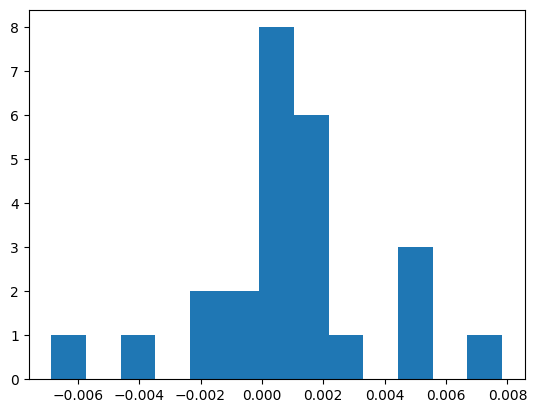

In [32]:
print(df.columns)
x = 'pf_pct_change'
plt.hist(df[x], bins="auto")
print(1-norm.cdf(0,df[x].mean()))
df[x].describe()

In [33]:
tickers_corr = df[[x+"_pct_change" for x in tickers]]
tickers_corr.corr()

,UUP_pct_change,JPY=X_pct_change,IBIT_pct_change,XLU_pct_change,XLF_pct_change,XLC_pct_change,XLY_pct_change,GLD_pct_change,SPY_pct_change,SHY_pct_change,USDCNY=X_pct_change
UUP_pct_change,1.000000,0.274673,-0.335343,-0.332253,-0.347521,-0.411016,-0.312141,-0.257495,-0.378556,-0.407471,-0.195366
JPY=X_pct_change,0.274673,1.000000,-0.039742,-0.171178,-0.081155,0.032159,-0.114753,-0.174804,-0.067132,-0.197510,-0.104027
IBIT_pct_change,-0.335343,-0.039742,1.000000,0.428550,0.264934,0.404405,0.424597,0.007220,0.481170,0.017718,0.030085
XLU_pct_change,-0.332253,-0.171178,0.428550,1.000000,0.435213,-0.048698,0.188516,0.413311,0.296790,0.149004,-0.088698
XLF_pct_change,-0.347521,-0.081155,0.264934,0.435213,1.000000,0.496132,0.679165,-0.123856,0.578026,0.784129,-0.243743
XLC_pct_change,-0.411016,0.032159,0.404405,-0.048698,0.496132,1.000000,0.613391,-0.132001,0.654763,0.543527,-0.003408
XLY_pct_change,-0.312141,-0.114753,0.424597,0.188516,0.679165,0.613391,1.000000,-0.200735,0.781776,0.600778,-0.109795
GLD_pct_change,-0.257495,-0.174804,0.007220,0.413311,-0.123856,-0.132001,-0.200735,1.000000,0.100938,0.026622,-0.054424
SPY_pct_change,-0.378556,-0.067132,0.481170,0.296790,0.578026,0.654763,0.781776,0.100938,1.000000,0.446848,0.033643
SHY_pct_change,-0.407471,-0.197510,0.017718,0.149004,0.784129,0.543527,0.600778,0.026622,0.446848,1.000000,-0.041256


In [34]:
def solve(df, capital, ticker):
    df[ticker+"_cumulative_returns"] = (1+df[ticker+"_pct_change"]).cumprod()
    df[ticker+"_val"] = capital*df[ticker+"_cumulative_returns"]
    return df

for i in [x for x in tickers]:
    df = solve(df,1000, i)

df.tail()

,UUP_Close,JPY=X_Close,IBIT_Close,XLU_Close,XLF_Close,XLC_Close,XLY_Close,GLD_Close,SPY_Close,SHY_Close,...,XLY_cumulative_returns,XLY_val,GLD_cumulative_returns,GLD_val,SPY_cumulative_returns,SPY_val,SHY_cumulative_returns,SHY_val,USDCNY=X_cumulative_returns,USDCNY=X_val
2025-01-29,29.389999,155.559006,59.340000,76.739998,51.279999,101.870003,230.940002,254.199997,601.809998,81.957199,...,1.043089,1043.089471,1.035775,1035.775401,1.029368,1029.368470,1.003294,1003.294287,0.993437,993.436621
2025-01-30,29.389999,155.169998,59.720001,78.339996,51.770000,101.970001,233.199997,258.049988,605.039978,82.007034,...,1.053297,1053.297215,1.051463,1051.462757,1.034893,1034.893204,1.003904,1003.904354,0.982310,982.310485
2025-01-31,29.510000,154.097000,57.709999,77.879997,51.470001,102.379997,232.169998,258.559998,601.820007,82.016998,...,1.048645,1048.645007,1.053541,1053.540867,1.029386,1029.385592,1.004026,1004.026330,0.983941,983.941040
2025-02-03,29.639999,155.363007,57.580002,78.300003,51.259998,102.599998,229.100006,259.940002,597.770020,81.959999,...,1.034779,1034.778737,1.059164,1059.163900,1.022458,1022.458273,1.003329,1003.328563,0.984612,984.612444
2025-02-04,29.420000,154.423996,56.264999,77.730003,51.125000,103.010002,230.313095,262.309906,599.865601,82.040001,...,1.040258,1040.257911,1.068820,1068.820422,1.026043,1026.042668,1.004308,1004.307921,0.993437,993.436621


UUP annualised vol 0.08579727647725131
{'UUP_val': 991.5739804733015, 'UUP_val_returns': -0.008426019526698525, 'UUP_val_sharpe': -1.9538601298689486, 'UUP_val_mdd': 0.021775531330772785}
UUP daily change = -0.007422379145909375
UUP WoW change = 0.0075342228632306885
JPY=X annualised vol 0.08913334349928695
{'JPY=X_val': 979.1084251652819, 'JPY=X_val_returns': -0.02089157483471804, 'JPY=X_val_sharpe': -3.992187677202343, 'JPY=X_val_mdd': 0.026157085034609857}
JPY=X daily change = -0.0060439781690396766
JPY=X WoW change = -0.011085157831314474
IBIT annualised vol 0.47102652739003753
{'IBIT_val': 1016.1639962981521, 'IBIT_val_returns': 0.016163996298152128, 'IBIT_val_sharpe': 0.6424881157505526, 'IBIT_val_mdd': 0.08509536022101517}
IBIT daily change = -0.022837832573618044
IBIT WoW change = -0.05753771071010416
XLU annualised vol 0.23173316436917052
{'XLU_val': 1019.1426088649225, 'XLU_val_returns': 0.019142608864922472, 'XLU_val_sharpe': 1.1368323476514282, 'XLU_val_mdd': 0.043347921154

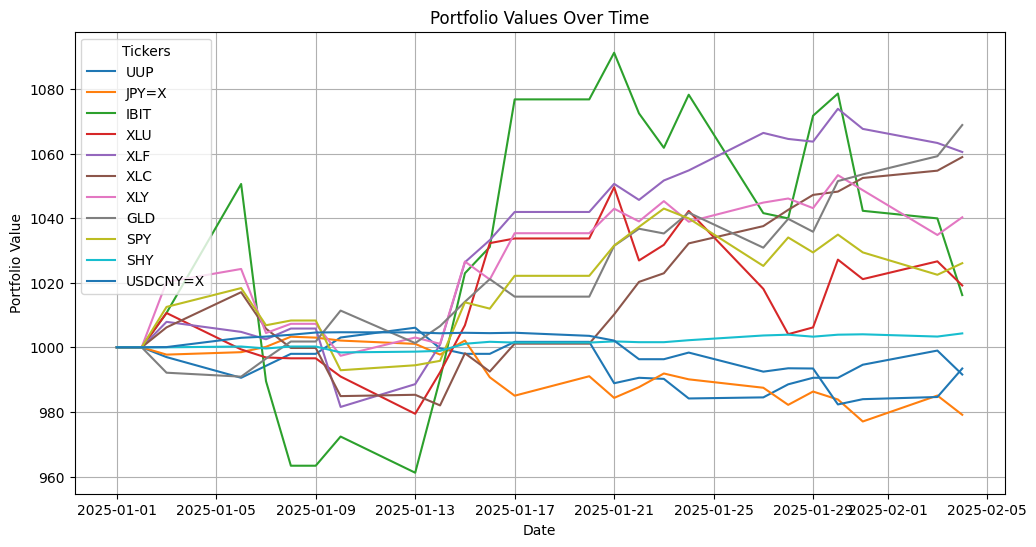

In [35]:
plt.figure(figsize=(12, 6))

# Loop through each ticker to calculate stats and plot
for i in tickers:
    print(i+" annualised vol", df[i+"_pct_change"].std() * np.sqrt(365))
    print(calculate_model_performance_stats(df, i+"_val"))
    print(i+" daily change =", df[i+"_pct_change"].iloc[-1])
    print(i+" WoW change =", df[i+"_val"].iloc[-1]/df[i+"_val"].iloc[-8]-1)
    # Plot the values
    plt.plot(df.index, df[i+"_val"], label=i)

# Add grid, legend, and labels
plt.grid(True)
plt.legend(title="Tickers")
plt.title("Portfolio Values Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.show()

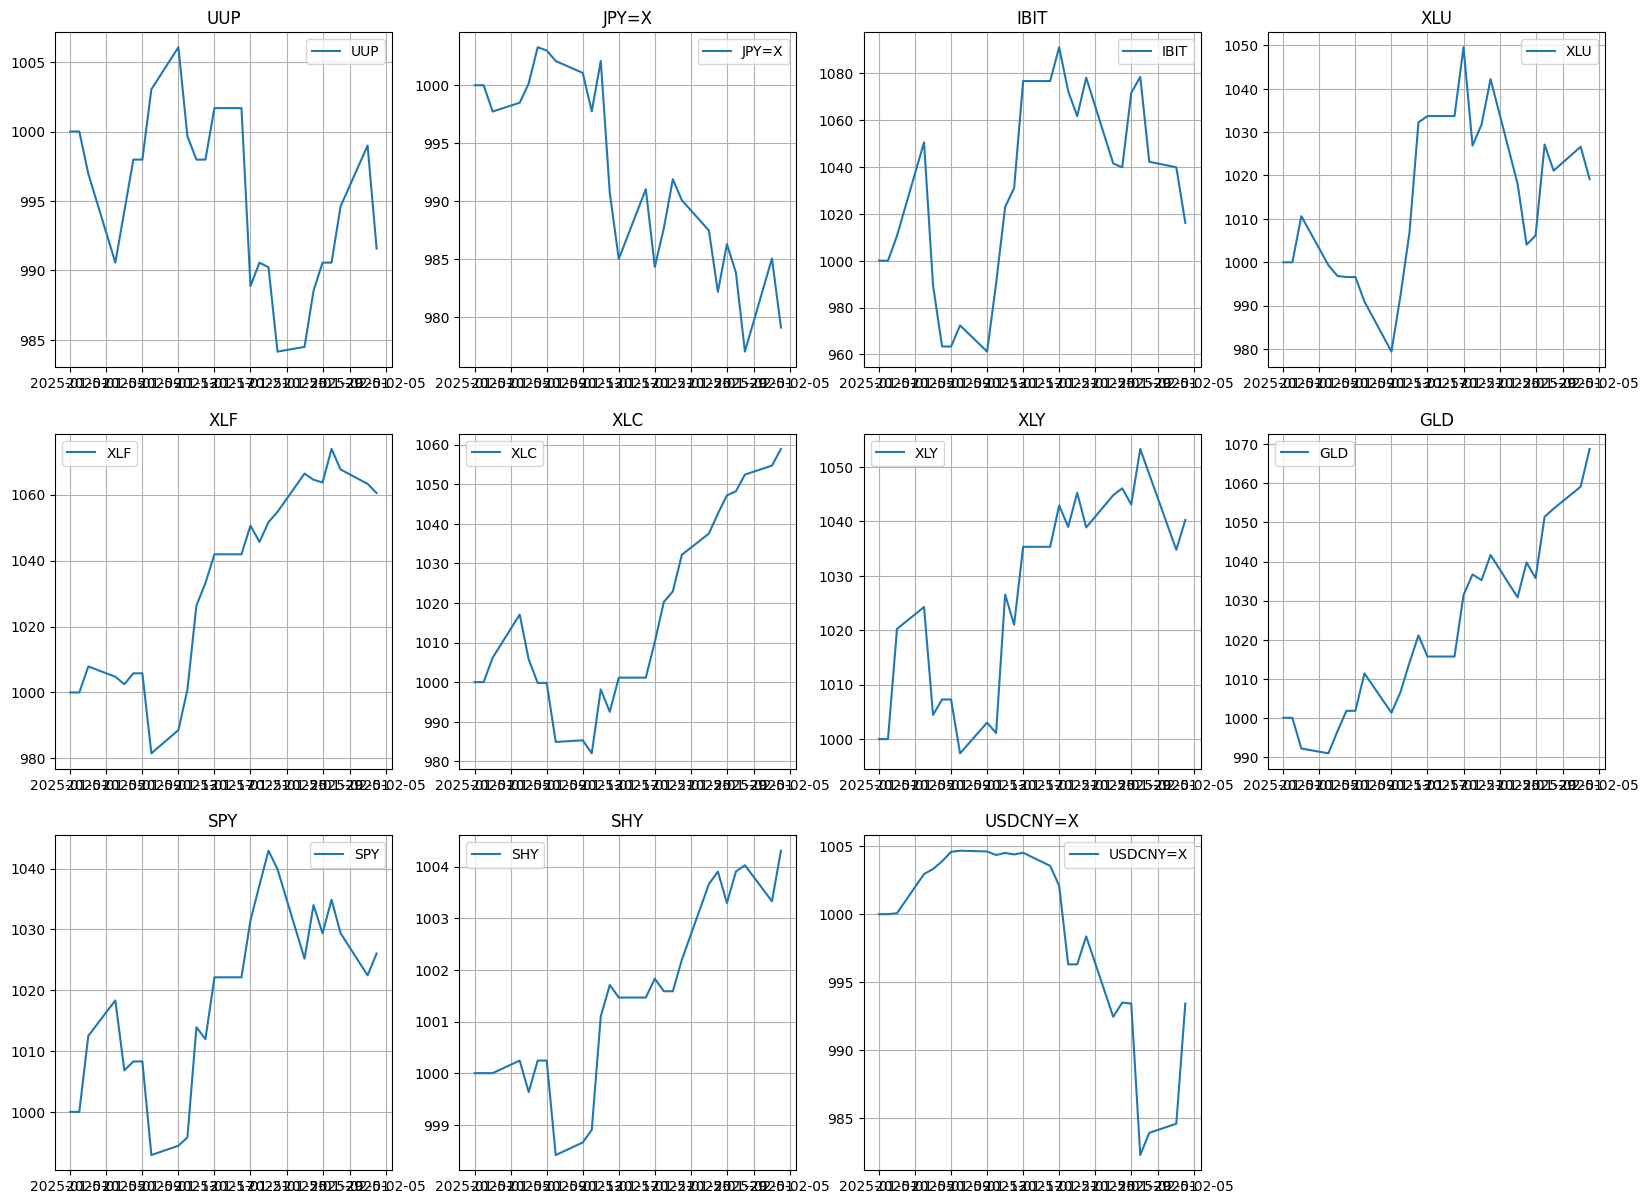

In [36]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # 3x3 grid

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through tickers and plot
for idx, ticker in enumerate(tickers):
    ax = axes[idx]  # Select subplot axis
    ax.plot(df.index, df[ticker + "_val"], label=ticker)
    ax.set_title(ticker)
    ax.legend()
    ax.grid()

# Remove unused subplots if tickers < 9
for idx in range(len(tickers), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
# plt.tight_layout()
plt.show()